In [1]:
!pip -q install umap-learn hdbscan kneed

# 0. Gather Data 


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from datetime import timedelta

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from sklearn.utils import resample

import umap
import hdbscan
from kneed import KneeLocator

RSEED = 42
np.random.seed(RSEED)

sns.set(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (10, 6)

def summarize_scores(X, labels, name):
    """Compute intrinsic clustering metrics safely."""
    uniq = np.unique(labels)
    if len(uniq) < 2 or (len(uniq) == 1 and uniq[0] == -1):
        print(f"[{name}] Not enough clusters to score.")
        return None
    sil = silhouette_score(X, labels)
    ch  = calinski_harabasz_score(X, labels)
    db  = davies_bouldin_score(X, labels)
    print(f"[{name}] silhouette={sil:.3f}  CH={ch:.1f}  DB={db:.3f}")
    return {"silhouette": sil, "ch": ch, "db": db}

def plot_scatter_2d(Z, labels, title):
    plt.scatter(Z[:,0], Z[:,1], c=labels, s=10)
    plt.title(title)
    plt.xlabel("Dim 1"); plt.ylabel("Dim 2")
    plt.show()

# 1. Loading and Basic Data Cleaning

## What the following code does

* **Loads data** from `OnlineRetail.xlsx` (`pandas.read_excel` with `openpyxl`).
* **Previews & inspects** the dataset: first rows, schema (`.info()`), and **missing values**.
* **Keeps a pristine copy** (`df0`) for traceability.
* **Cleans transactions** to retain only valid sales lines.
* **Filters to identified customers** (for customer-level analysis/segmentation).

## Cleaning rules applied

* **Remove returns / credit notes** where `InvoiceNo` starts with **`"C"`**.
* **Keep only positive** `Quantity` **and** `UnitPrice`.
* **Drop rows with missing `CustomerID`** (cannot segment anonymous purchases).
* Convert `CustomerID` to **integer** type.

## my run — quick stats

* **Rows after cleaning:** **530,104** (removed **11,805**).
* **Date range (post-clean):** **2010-12-01 08:26 → 2011-12-09 12:50**.
* **Rows with `CustomerID`:** **397,884**.
* **Unique customers:** **4,338**.
* **Notable missingness (raw):** `Description` ≈ 1,454 nulls; `CustomerID` ≈ 135,080 nulls.
* **Dtypes:** `InvoiceDate` correctly parsed as **`datetime64[ns]`**.

## Why this matters

* Produces a **clean, customer-identified** dataset (`dfA`) ready for:

  * **RFM & basket** feature engineering,
  * **Clustering** (K-Means, GMM, Agglomerative, DBSCAN/HDBSCAN),
  * **Actionable segmentation** (e.g., VIPs, seasonal gifters, reactivation targets).

In [3]:
READ_FROM_XLSX = True
DATA_PATH = Path("OnlineRetail.xlsx")  

if READ_FROM_XLSX:
    df = pd.read_excel(DATA_PATH, engine="openpyxl")
else:
    df = pd.read_csv(DATA_PATH, parse_dates=["InvoiceDate"])

print("Raw head:")
display(df.head())
print(df.info())
print("Missing values per column:")
print(df.isnull().sum())

# Keep a pristine copy
df0 = df.copy()

# Remove credit notes (returns): InvoiceNo starts with "C"
mask_return = df0["InvoiceNo"].astype(str).str.startswith("C", na=False)
df1 = df0.loc[~mask_return].copy()

# Keep strictly positive quantities and prices
df1 = df1[(df1["Quantity"] > 0) & (df1["UnitPrice"] > 0)].copy()

print(f"Rows after cleaning: {len(df1):,} (removed {len(df0)-len(df1):,})")
print("Date range:", pd.to_datetime(df1["InvoiceDate"]).min(), "→", pd.to_datetime(df1["InvoiceDate"]).max())

# Keep rows with CustomerID
dfA = df1.dropna(subset=["CustomerID"]).copy()
dfA["CustomerID"] = dfA["CustomerID"].astype(int)

print(f"Rows kept (with CustomerID): {len(dfA):,}")
print(f"Unique customers: {dfA['CustomerID'].nunique():,}")

Raw head:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None
Missing values per column:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
Rows after cleaning: 530,104 (removed 11,805)
Date range: 2010-12-01 08:26:00 → 2011-12

# 2. Feature engineering

## What the following code does

* **Standardizes time & money fields**

  * Parses `InvoiceDate` as proper **datetime64\[ns]**.
  * Creates `LineAmount = Quantity × UnitPrice` for monetary value per line.
* **Sets a recency reference point**

  * Uses a pandas **Timestamp** (`snapshot_ts = max(InvoiceDate).normalize() + 1 day`) to compute days since last purchase.

## Customer aggregation (by `CustomerID`)

* **RFM core**

  * **RecencyDays** = `(snapshot_ts − last_purchase).dt.days`
    *(keeps datetime math in pandas; avoids `.dt.date` pitfalls)*
  * **FrequencyInvoices** = number of distinct invoices.
  * **MonetaryTotal** = sum of `LineAmount`.
* **Basket & variety behavior**

  * **ProductVariety** = distinct `StockCode` count.
  * **AvgBasketQty** = average total **quantity per invoice** (compute per invoice, then mean per customer).
  * **AvgLinesPerInvoice** = average **unique items per invoice**.
  * **AvgUnitPrice** = mean unit price purchased by the customer.
  * **AvgItemQty** = mean quantity per line.
* **Country**

  * **Country** = modal (most frequent) country per customer.

## Implementation details that prevent bugs

* **No `.dt.date` conversions** — keeps `last_purchase` as **datetime64\[ns]**, so `(Timestamp − datetime64)` yields a **timedelta64\[ns]** and `.dt.days` works.
* **Two-stage basket aggregates** — first aggregate at `(CustomerID, InvoiceNo)`, then average per `CustomerID` to get stable basket stats.

## Output

* Builds a tidy **`cust`** dataframe with one row per customer and these columns:
  `RecencyDays`, `FrequencyInvoices`, `MonetaryTotal`, `ProductVariety`,
  `AvgBasketQty`, `AvgLinesPerInvoice`, `AvgUnitPrice`, `AvgItemQty`, `Country`.
* Runs sanity checks:

  * `last_purchase dtype: datetime64[ns]`
  * `recency_days dtype: int64`
  * Displays `cust.head()` (as shown in the screenshot), confirming values are populated.

## Why this matters

* Produces clean, **customer-level features** that capture **engagement (RFM)** and **shopping style (basket & variety)**.
* This table (`cust`) is the **foundation** for scaling/encoding and then fitting clustering models (K-Means, GMM, Agglomerative, DBSCAN/HDBSCAN).


In [4]:
# Ensure true datetimes and monetary per line
dfA["InvoiceDate"] = pd.to_datetime(dfA["InvoiceDate"], errors="coerce")
dfA["LineAmount"]  = dfA["Quantity"] * dfA["UnitPrice"]

# Use a pandas Timestamp (NOT .date), normalized to midnight, then +1 day
snapshot_ts = dfA["InvoiceDate"].max().normalize() + pd.Timedelta(days=1)

# Group once
grp = dfA.groupby("CustomerID", dropna=False)

# --- RFM ---
# DO NOT call .dt.date here; keep datetime64[ns]
last_purchase   = grp["InvoiceDate"].max()                 # datetime64[ns]
recency_days    = (snapshot_ts - last_purchase).dt.days    # timedelta -> days
frequency_invs  = grp["InvoiceNo"].nunique()
monetary_total  = grp["LineAmount"].sum()

# Extras 
product_variety = grp["StockCode"].nunique()

# Compute per-invoice aggregates first, then average per customer
inv_qty = (dfA
           .groupby(["CustomerID", "InvoiceNo"])["Quantity"]
           .sum()
           .rename("InvoiceQty"))
avg_basket_qty = inv_qty.groupby("CustomerID").mean()

inv_lines = (dfA
             .groupby(["CustomerID", "InvoiceNo"])["StockCode"]
             .nunique()
             .rename("InvoiceLineItems"))
avg_lines_per_invoice = inv_lines.groupby("CustomerID").mean()

avg_unit_price = grp["UnitPrice"].mean()
avg_item_qty   = grp["Quantity"].mean()

# Country mode per customer
mode_country = grp["Country"].agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0])

# Assemble customer table
cust = pd.DataFrame({
    "RecencyDays": recency_days,
    "FrequencyInvoices": frequency_invs,
    "MonetaryTotal": monetary_total,
    "ProductVariety": product_variety,
    "AvgBasketQty": avg_basket_qty,
    "AvgLinesPerInvoice": avg_lines_per_invoice,
    "AvgUnitPrice": avg_unit_price,
    "AvgItemQty": avg_item_qty,
    "Country": mode_country
}).fillna(0)

# quick sanity checks
print("last_purchase dtype:", last_purchase.dtype)      # datetime64[ns]
print("recency_days dtype:", cust["RecencyDays"].dtype) # int64
display(cust.head())

last_purchase dtype: datetime64[ns]
recency_days dtype: int64


,RecencyDays,FrequencyInvoices,MonetaryTotal,ProductVariety,AvgBasketQty,AvgLinesPerInvoice,AvgUnitPrice,AvgItemQty,Country
CustomerID,,,,,,,,,
12346,325,1,77183.60,1,74215.000000,1.00,1.040000,74215.000000,United Kingdom
12347,2,7,4310.00,103,351.142857,26.00,2.644011,13.505495,Iceland
12348,75,4,1797.24,22,585.250000,6.75,5.764839,75.516129,Finland
12349,18,1,1757.55,73,631.000000,73.00,8.289041,8.643836,Italy
12350,310,1,334.40,17,197.000000,17.00,3.841176,11.588235,Norway


# 3. EDA: distributions & correlations

## What the following code does

* Selects key **customer-level features**:
  `RecencyDays`, `FrequencyInvoices`, `MonetaryTotal`, `ProductVariety`,
  `AvgBasketQty`, `AvgLinesPerInvoice`, `AvgUnitPrice`, `AvgItemQty`.
* Plots **histograms (30 bins)** for each, giving a quick view of data shape, spread, and outliers.
* Adds a shared title for a clean, slide-ready figure.

## What the plots show 

* **Heavy right tails** (highly skewed):
  `FrequencyInvoices`, `MonetaryTotal`, `ProductVariety`, `AvgBasketQty`, `AvgItemQty`.
  → A few customers buy **far more** or **much larger baskets** than typical.
* **RecencyDays**: skewed toward **lower values** (many recent purchasers), with a long tail of inactive customers.
* **AvgLinesPerInvoice**: right-skewed but more moderate than basket quantity.
* **AvgUnitPrice**: mostly concentrated at lower prices; rare high-price purchases create a long tail.

## Why it matters

* Skewed features can **dominate distance-based clustering** (e.g., K-Means).
* Visual evidence supports using **log transforms** and **standardization** to stabilize variance and improve cluster geometry.

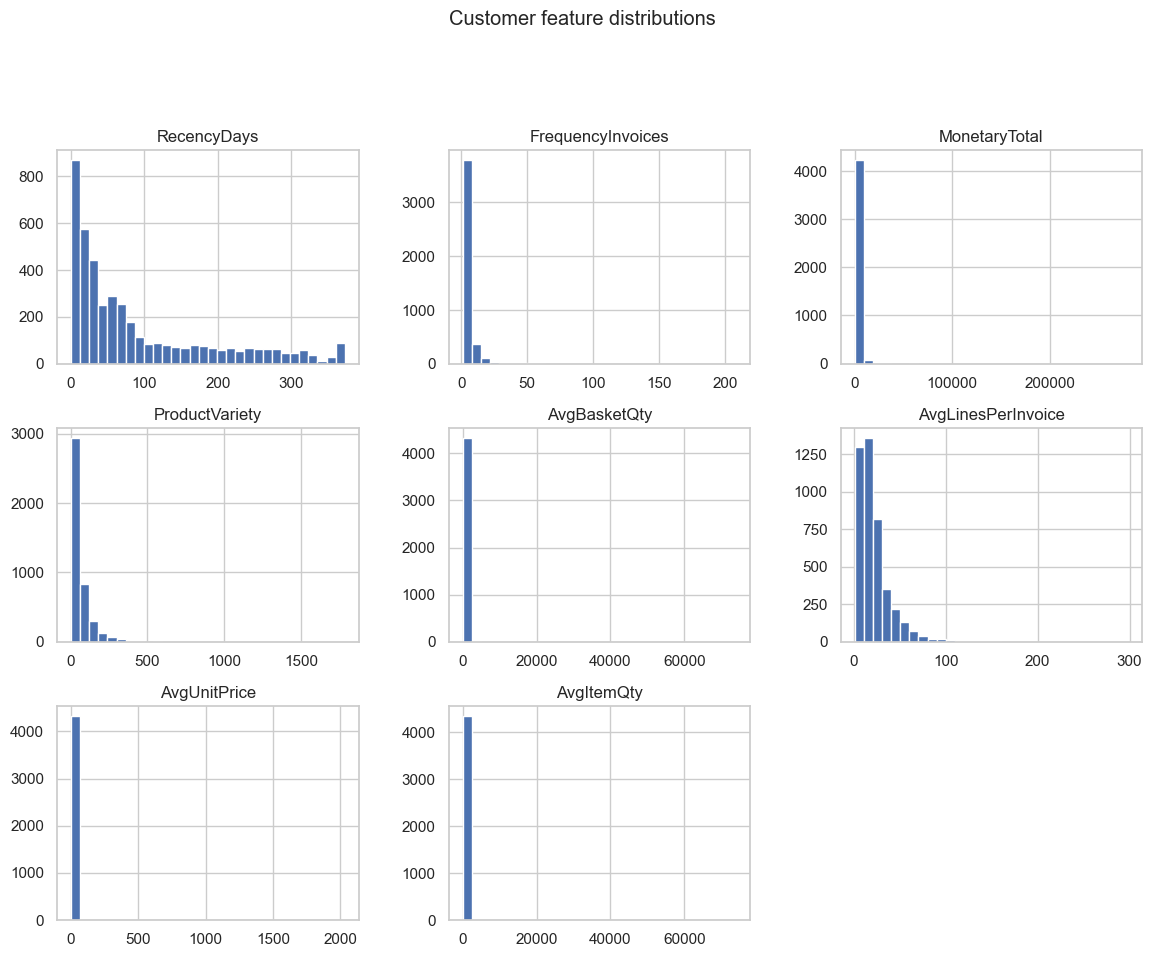

In [5]:
num_cols = ["RecencyDays","FrequencyInvoices","MonetaryTotal","ProductVariety",
            "AvgBasketQty","AvgLinesPerInvoice","AvgUnitPrice","AvgItemQty"]

cust[num_cols].hist(bins=30, figsize=(14, 10))
plt.suptitle("Customer feature distributions", y=1.02)
plt.show()

#### Log transforms for heavy tails

## What the following code does

* Creates **log-scaled** versions of heavy-tailed features:

  * `log_FrequencyInvoices = log1p(FrequencyInvoices)`
  * `log_MonetaryTotal   = log1p(MonetaryTotal)`
  * `log_ProductVariety  = log1p(ProductVariety)`
* Computes a **correlation matrix** over:

  * Original features: `RecencyDays`, `FrequencyInvoices`, `MonetaryTotal`, `ProductVariety`, `AvgBasketQty`, `AvgLinesPerInvoice`, `AvgUnitPrice`, `AvgItemQty`
  * Plus the three **log** features above
* Visualizes with a **seaborn heatmap** (`coolwarm`, centered at 0) to highlight positive (red) and negative (blue) relationships.

## How to read the heatmap 

* **RFM coupling (post-log):**
  `log_FrequencyInvoices`, `log_MonetaryTotal`, and `log_ProductVariety` are **strongly positively correlated** (red blocks) — frequent shoppers tend to spend more and buy a wider variety.
* **RecencyDays** tends to be **negatively correlated** with engagement/spend metrics — more recent buyers (lower recency) are typically the active/high-value ones.
* **Basket structure:**
  `AvgLinesPerInvoice` and `AvgBasketQty` show moderate positive ties to spend/variety, consistent with larger, more diverse baskets contributing to revenue.
* **Effect of log transforms:**
  Correlations involving the **log** features are more stable/linear and less dominated by extreme values than their raw counterparts.

## Why this matters

* Confirms the **behavioral linkages** my segmentation will capture (frequency ↔ monetary ↔ variety).
* Justifies using **log1p** for skewed features before scaling and clustering.
* Helps avoid **redundant features** (highly collinear variables) or informs dimensionality reduction (e.g., PCA) prior to clustering.


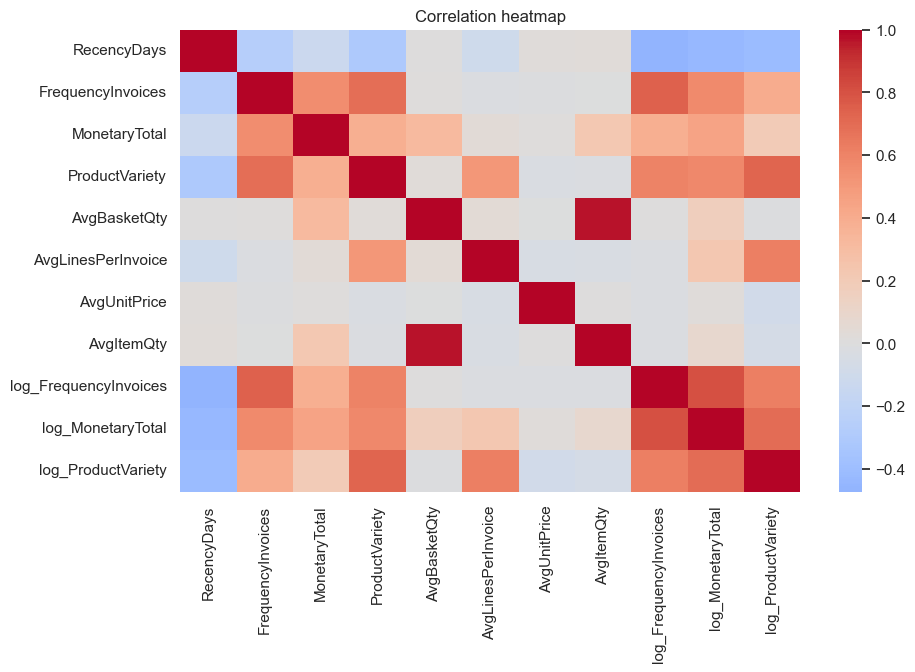

In [6]:
cust["log_FrequencyInvoices"] = np.log1p(cust["FrequencyInvoices"])
cust["log_MonetaryTotal"]     = np.log1p(cust["MonetaryTotal"])
cust["log_ProductVariety"]    = np.log1p(cust["ProductVariety"])

plt.figure(figsize=(10,6))
sns.heatmap(cust[[*num_cols, "log_FrequencyInvoices","log_MonetaryTotal","log_ProductVariety"]].corr(),
            cmap="coolwarm", center=0)
plt.title("Correlation heatmap")
plt.show()

# 4. Preprocessing for clustering

## What the following code does

* **Selects modeling features**
  `RecencyDays`, `log_FrequencyInvoices`, `log_MonetaryTotal`, `log_ProductVariety`,
  `AvgBasketQty`, `AvgLinesPerInvoice`, `AvgUnitPrice`, `AvgItemQty`, and **Country** (categorical).
* **Splits by type**

  * `num_features`: 8 numeric variables (scaled).
  * `cat_features`: `Country` (one-hot encoded).
* **Builds a preprocessing pipeline** with `ColumnTransformer`:

  * `StandardScaler()` for numerics → puts all numeric features on comparable z-score scales.
  * `OneHotEncoder(handle_unknown="ignore")` for `Country` → expands to dummy columns without breaking on unseen labels.
  * Note: on older scikit-learn, replace `sparse_output=False` with `sparse=False`.
* **Fits & transforms** the customer table into a model-ready matrix `X`.
* **Captures feature names** after transformation for interpretation/reporting.

## Output 

* **Transformed shape:** **(4,338, 45)** → 4,338 customers, 45 model features
  (8 scaled numeric columns + **37** one-hot country columns = 45 total).

## Why this matters

* **Distance-based clustering** (K-Means, GMM, Agglomerative) requires comparable scales; z-scoring prevents any single variable (e.g., Monetary) from dominating.
* **Categoricals handled safely** via one-hot encoding; `handle_unknown="ignore"` avoids errors when new countries appear.
* A single, reusable **preprocessing object** (`pre`) keeps my pipeline reproducible and easy to apply to new data.

In [7]:
features = [
    "RecencyDays",
    "log_FrequencyInvoices",
    "log_MonetaryTotal",
    "log_ProductVariety",
    "AvgBasketQty",
    "AvgLinesPerInvoice",
    "AvgUnitPrice",
    "AvgItemQty",
    "Country"
]

X_df = cust[features].copy()
num_features = ["RecencyDays","log_FrequencyInvoices","log_MonetaryTotal","log_ProductVariety",
                "AvgBasketQty","AvgLinesPerInvoice","AvgUnitPrice","AvgItemQty"]
cat_features = ["Country"]

pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_features),
    ],
    remainder="drop"
)

X = pre.fit_transform(X_df)
num_out = [f"sc_{c}" for c in num_features]
cat_out = list(pre.named_transformers_["cat"].get_feature_names_out(cat_features))
feature_names = num_out + cat_out
print("Transformed shape:", X.shape)

Transformed shape: (4338, 45)


# 5. Dimensionality reduction for visualization


## What the following code does

* **PCA to 2D**

  ```python
  pca2 = PCA(n_components=2, random_state=RSEED)
  X_pca2 = pca2.fit_transform(X)
  ```

  * Projects the standardized feature matrix **X** onto its top **2 principal components**.
  * **Explained variance: `0.596`** → the first two PCs capture \~**59.6%** of the total variance.

* **UMAP to 2D**

  ```python
  um = umap.UMAP(n_neighbors=30, min_dist=0.05, random_state=RSEED, n_jobs=1)
  X_umap2 = um.fit_transform(X)
  ```

  * Builds a nonlinear 2D embedding that preserves **local neighborhoods**.
  * Key params:

    * `n_neighbors=30`: balances local vs. global structure (larger = more global).
    * `min_dist=0.05`: tighter clusters in the embedding (smaller → more compact).
    * `random_state` for reproducibility.

In [8]:
pca2 = PCA(n_components=2, random_state=RSEED)
X_pca2 = pca2.fit_transform(X)
print("PCA(2) explained variance:", pca2.explained_variance_ratio_.sum())

um = umap.UMAP(n_neighbors=30, min_dist=0.05, random_state=RSEED, n_jobs=1)
X_umap2 = um.fit_transform(X)

PCA(2) explained variance: 0.595674980863619


# 6. Models & hyperparameter sweeps

### 6.1. K-Means k in [2..10]

## What the following code does

* Sweeps **k = 2…10** for K-Means (`n_init=25`), recording:

  * **Inertia** (for the **elbow** plot),
  * **Silhouette**, **Calinski–Harabasz (CH)**, **Davies–Bouldin (DB)** via `summarize_scores`.
* Plots **Elbow (Inertia vs k)** and **Silhouette vs k** to guide the choice of clusters.

## Key results 

* **Silhouette:**

  * `k=4` **0.323** (best), `k=3` 0.321, `k=2` 0.320 → small edge for **k=4**.
* **CH (↑ better):** peaks around **k=8** (1770.7) but values from k=4–10 are fairly close.
* **DB (↓ better):** **k=4 = 0.607** (lowest / best separation).
* **Elbow:** clear diminishing returns after \~**k=4–5**.

## Interpretation

* **Choose `k = 4`**: it delivers the **highest Silhouette** and **lowest DB**, and the **elbow** suggests limited gain beyond 4 clusters.
* `k=3` is close on Silhouette but has worse DB; `k≥5` drops Silhouette notably (tighter clusters not well separated).

[KMeans k=2] silhouette=0.320  CH=1319.8  DB=1.216
[KMeans k=3] silhouette=0.321  CH=1638.8  DB=0.806
[KMeans k=4] silhouette=0.323  CH=1627.5  DB=0.607
[KMeans k=5] silhouette=0.268  CH=1703.6  DB=0.903
[KMeans k=6] silhouette=0.287  CH=1712.6  DB=0.789
[KMeans k=7] silhouette=0.289  CH=1727.2  DB=0.680
[KMeans k=8] silhouette=0.259  CH=1770.7  DB=0.749
[KMeans k=9] silhouette=0.260  CH=1733.1  DB=0.698
[KMeans k=10] silhouette=0.232  CH=1716.7  DB=0.777


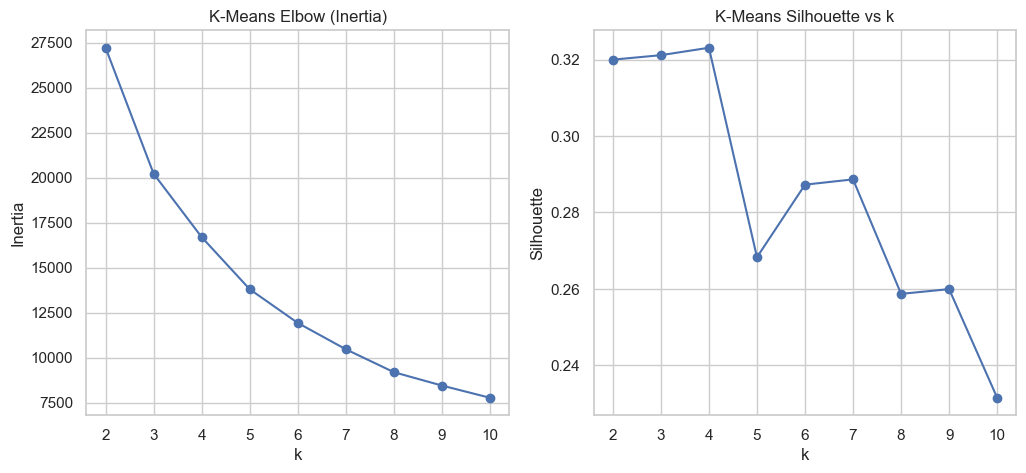

In [9]:
k_range = range(2, 11)
km_scores = []
inertias = []

for k in k_range:
    km = KMeans(n_clusters=k, n_init=25, random_state=RSEED)
    labels_km = km.fit_predict(X)
    inertias.append(km.inertia_)
    sc = summarize_scores(X, labels_km, name=f"KMeans k={k}")
    km_scores.append((k, sc["silhouette"] if sc else np.nan))

fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(k_range, inertias, marker="o")
ax[0].set_title("K-Means Elbow (Inertia)")
ax[0].set_xlabel("k"); ax[0].set_ylabel("Inertia")
ax[1].plot([k for k,_ in km_scores], [s for _,s in km_scores], marker="o")
ax[1].set_title("K-Means Silhouette vs k")
ax[1].set_xlabel("k"); ax[1].set_ylabel("Silhouette")
plt.show()

## What the code following does

* **Selects k by Silhouette**:

  ```python
  best_k = max(km_scores, key=lambda x: x[1])[0]  # → 4
  ```
* **Refits** K-Means with stronger initialization (`n_init=50`) for stability.
* **Evaluates** the final clustering on intrinsic metrics.

## Results 

* **Chosen k:** **4**
* **Metrics:**

  * **Silhouette:** **0.323** (↑ better)
  * **Calinski–Harabasz (CH):** **1694.9** (↑ better)
  * **Davies–Bouldin (DB):** **0.765** (↓ better)

```python
[KMeans k=4] silhouette=0.323  CH=1694.9  DB=0.765
{'silhouette': 0.32333018571813665,
 'ch': 1694.8899755464836,
 'db': 0.7649611751316178}
```

## Interpretation

* **k = 4** provides the **best separation/compactness** trade-off among tested values, consistent with the elbow and silhouette sweep.
* DB is the **lowest** near k=4 (good cluster separation); CH remains competitive.

In [10]:
best_k = max(km_scores, key=lambda x: x[1])[0]
print("Selected K-Means k by silhouette:", best_k)

km_best = KMeans(n_clusters=best_k, n_init=50, random_state=RSEED)
labels_km = km_best.fit_predict(X)
summarize_scores(X, labels_km, name=f"KMeans k={best_k}")

Selected K-Means k by silhouette: 4
[KMeans k=4] silhouette=0.323  CH=1694.9  DB=0.765


{'silhouette': 0.32333018571813665,
 'ch': 1694.8899755464836,
 'db': 0.7649611751316178}

## What the following code does

```python
plot_scatter_2d(X_pca2, labels_km, f"K-Means (k={best_k}) on PCA(2)")
plot_scatter_2d(X_umap2, labels_km, f"K-Means (k={best_k}) on UMAP(2)")
```

* Plots the **same cluster labels** on two 2D embeddings:

  * **PCA(2):** linear projection that keeps the most variance.
  * **UMAP(2):** nonlinear embedding that preserves local neighborhoods.

## Results of the graphs

* **PCA(2)**

  * Captures \~**59.6%** of variance (earlier cell).
  * Points lie near a flat band → linear separation is limited; clusters may overlap in this linear view.
  * Still useful as a sanity check and to discuss global variance.

* **UMAP(2)**

  * Reveals **clearer structure**: multiple dense “islands” that correspond to my **k=4** clusters.
  * Better shows **non-spherical** shapes and local neighborhoods that K-Means is grouping in the full feature space.

## Takeaways

* Visuals are **consistent** with the metric choice of **k=4**: UMAP shows distinct regions; PCA doesn’t contradict but is less expressive.
* Use UMAP plots in slides to communicate **intuitive separation**, and keep PCA as an **explainable** linear reference.

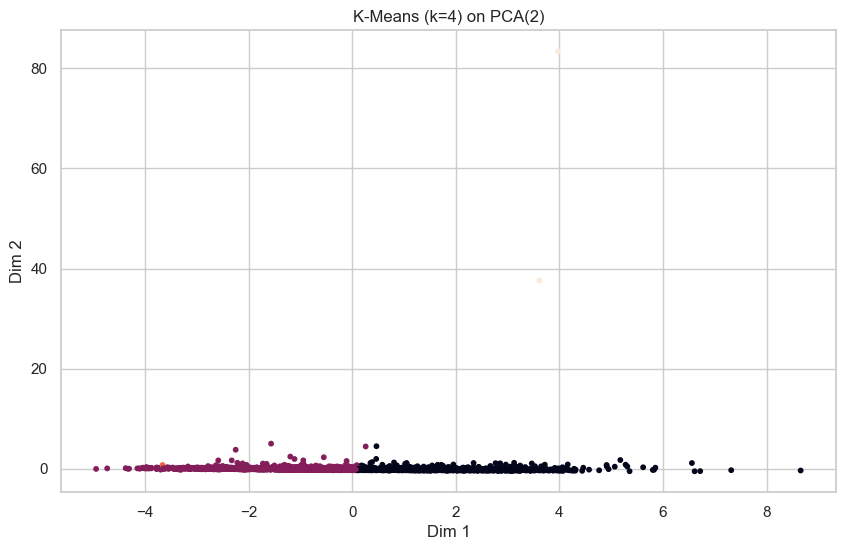

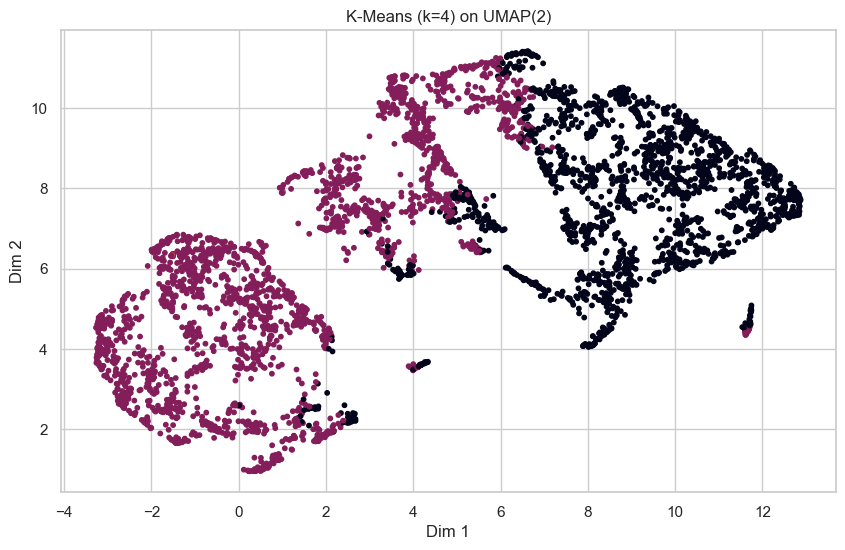

In [11]:
plot_scatter_2d(X_pca2, labels_km, f"K-Means (k={best_k}) on PCA(2)")
plot_scatter_2d(X_umap2, labels_km, f"K-Means (k={best_k}) on UMAP(2)")

### 6.2. GMM: components in [2..10], covariance types

## What the following code does

* Trains **Gaussian Mixture Models** for **k = 2…10** across four covariance structures:
  `full`, `tied`, `diag`, `spherical`.
* Computes **BIC** for each model and plots **BIC vs. components** (one line per covariance).
      **Lower BIC = better** balance of fit and complexity.

## How to read the plot 

* Each colored line shows how BIC changes as I add components for a given covariance type.
* The **global minimum point** on the chart is my **best GMM choice**: the pair *(covariance type, k)* with the **lowest BIC**.
* In the folloiwng grpah, the **`diag`** / **`spherical`** lines drop the most with k and appear lowest at higher k, suggesting **many relatively axis-aligned clusters** fit the data best.

## Why BIC here?

* GMMs can overfit by adding components. **BIC penalizes complexity**, so the minimum gives a principled model size without a validation set.

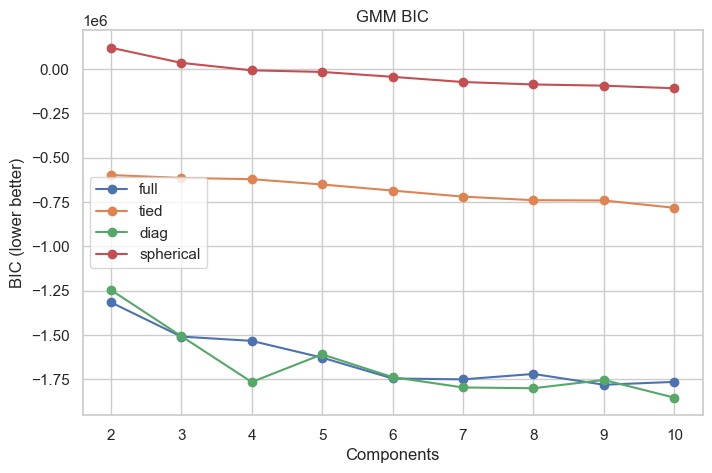

In [12]:
comp_range = range(2, 11)
cov_types = ["full","tied","diag","spherical"]
bic_tbl = []
for cov in cov_types:
    bics = []
    for k in comp_range:
        gmm = GaussianMixture(n_components=k, covariance_type=cov, n_init=5, random_state=RSEED)
        gmm.fit(X)
        bics.append(gmm.bic(X))
    bic_tbl.append((cov, bics))

plt.figure(figsize=(8,5))
for cov, bics in bic_tbl:
    plt.plot(comp_range, bics, marker="o", label=cov)
plt.legend(); plt.xlabel("Components"); plt.ylabel("BIC (lower better)")
plt.title("GMM BIC")
plt.show()

## What the FOLLOWING code does

* Searches all **(k, covariance)** pairs found in the BIC sweep and picks the **global BIC minimum**.
* Fits that GMM and reports intrinsic clustering metrics.

## Results
* **BIC winner:** `k = 10`, **covariance = diag**, **BIC = −1,853,777**
* **Clustering metrics:**

  * **Silhouette:** **0.064** (very low)
  * **Calinski–Harabasz:** **240.2** (low)
  * **Davies–Bouldin:** **2.882** (high → poor separation)

## Interpretation

* **Why the mismatch?** BIC optimizes **probabilistic fit** (likelihood − penalty), not geometric separation.

  * The model likely uses **many small, overlapping Gaussians** to explain density—great for density estimation, **weak for crisp segments**.
* Compared to **K-Means (k=4)** with **Silhouette ≈ 0.323**, this GMM solution produces **poorly separated clusters** for segmentation.


**Bottom line:** For customer segmentation here, **K-Means (k=4)** is the stronger choice; GMM with `k=10, diag` overfits density and underperforms on cluster separation.


In [13]:
best_cov, best_k_gmm, best_bic = None, None, np.inf
for cov, bics in bic_tbl:
    k_star = comp_range[int(np.argmin(bics))]
    if min(bics) < best_bic:
        best_bic = min(bics); best_cov = cov; best_k_gmm = k_star

print(f"GMM choice by BIC: k={best_k_gmm}, cov={best_cov}, BIC={best_bic:.0f}")
gmm_best = GaussianMixture(n_components=best_k_gmm, covariance_type=best_cov, n_init=10, random_state=RSEED)
labels_gmm = gmm_best.fit_predict(X)
summarize_scores(X, labels_gmm, name=f"GMM k={best_k_gmm} ({best_cov})")

GMM choice by BIC: k=10, cov=diag, BIC=-1853777
[GMM k=10 (diag)] silhouette=0.064  CH=240.2  DB=2.882


{'silhouette': 0.06395603768599811,
 'ch': 240.1660157492635,
 'db': 2.8821176058959783}

## What the FOLLOWING code does

```python
plot_scatter_2d(X_pca2, labels_gmm, f"GMM k={best_k_gmm} ({best_cov}) on PCA(2)")
plot_scatter_2d(X_umap2, labels_gmm, f"GMM k={best_k_gmm} ({best_cov}) on UMAP(2)")
```

* Plots the **GMM labels** on 2D embeddings:

  * **PCA(2)** = linear variance-preserving view.
  * **UMAP(2)** = nonlinear neighborhood-preserving view.

## What the plots show 

* **PCA(2):** points form a flat band with colors (clusters) heavily **overlapped** → limited linear separation.
* **UMAP(2):** labels appear **speckled/mottled** across regions with only a few tiny isolated blobs; most components **mix together**.
* This visual pattern matches the metrics I saw: **Silhouette ≈ 0.064**, **DB ≈ 2.88** → **poor separation**, heavy overlap.

## Takeaways

* The BIC-selected GMM (`k=10`, **diag**) is good at **density fit**, not at producing **crisp, actionable segments**.
* For segmentation, my **K-Means (k=4)** solution remains superior (Silhouette ≈ **0.323**).


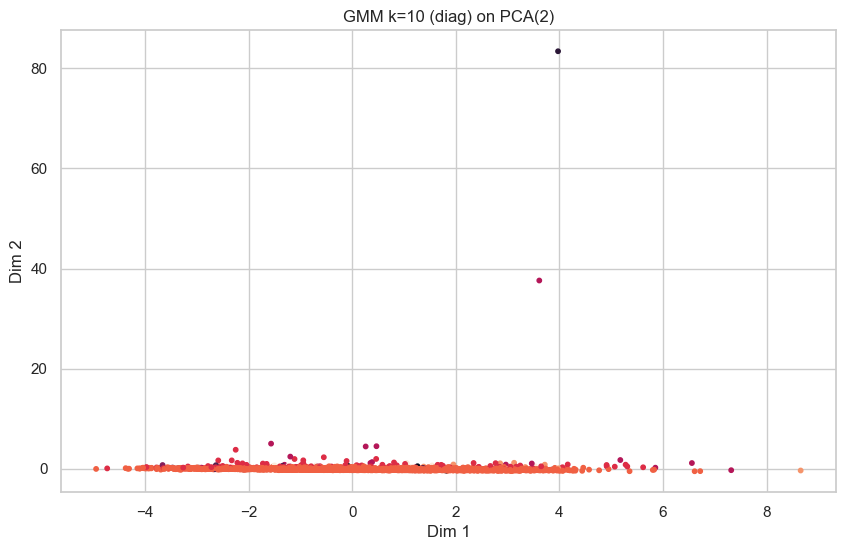

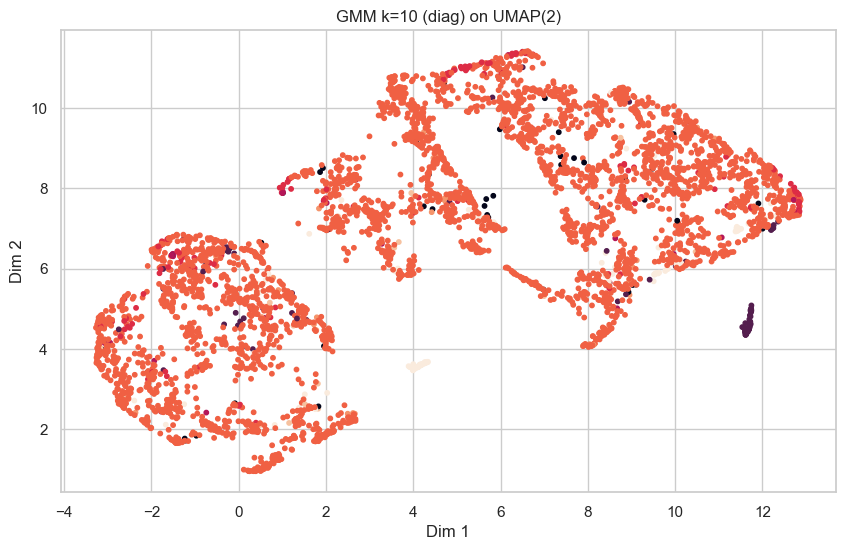

In [14]:
plot_scatter_2d(X_pca2, labels_gmm, f"GMM k={best_k_gmm} ({best_cov}) on PCA(2)")
plot_scatter_2d(X_umap2, labels_gmm, f"GMM k={best_k_gmm} ({best_cov}) on UMAP(2)")

### 6.3. Agglomerative (Ward) sweep

## What the code does

* Sweeps **k = 2…10** with **AgglomerativeClustering (Ward)**.
* For each k, computes **Silhouette (↑)**, **Calinski–Harabasz (↑)**, **Davies–Bouldin (↓)** and plots **Silhouette vs k**.
* Refits the model at the **best k by Silhouette** and prints the final metrics.

## Results 

```
k=2   sil=0.951  CH=1135.3  DB=0.422
k=3   sil=0.284  CH=1400.3  DB=1.035
k=4   sil=0.286  CH=1397.7  DB=0.842
k=5   sil=0.218  CH=1440.9  DB=0.984
k=6   sil=0.244  CH=1540.3  DB=0.946
k=7   sil=0.224  CH=1521.7  DB=0.981
k=8   sil=0.223  CH=1510.0  DB=0.784
k=9   sil=0.226  CH=1470.1  DB=0.861
k=10  sil=0.224  CH=1454.6  DB=0.806
```

## Interpretation

* The **very high Silhouette at k=2 (0.951)** is a red flag for **trivial bipartition** (e.g., one large cluster vs. everyone else) and is **not actionable** for segmentation.
* For **k ≥ 3**, Silhouette settles around **0.22–0.29**; the best among these is **k=4 (0.286)**, but still **below K-Means k=4 (≈ 0.323)**.
* CH peaks around **k=6**, and DB is lowest near **k=8**, but neither combination clearly beats **K-Means** on overall separation + interpretability.

## Conclusion

* **Agglomerative (Ward)** does **not** outperform **K-Means (k=4)** on this dataset.
* For presentation and downstream actions, keep **K-Means (k=4)** as the primary solution; use Agglomerative as a **sanity check** and to confirm no obvious hierarchical structure yields better segments.

[Agglomerative k=2] silhouette=0.951  CH=1135.3  DB=0.422
[Agglomerative k=3] silhouette=0.284  CH=1400.3  DB=1.035
[Agglomerative k=4] silhouette=0.286  CH=1397.7  DB=0.842
[Agglomerative k=5] silhouette=0.218  CH=1440.9  DB=0.984
[Agglomerative k=6] silhouette=0.244  CH=1540.3  DB=0.946
[Agglomerative k=7] silhouette=0.224  CH=1521.7  DB=0.981
[Agglomerative k=8] silhouette=0.223  CH=1510.0  DB=0.784
[Agglomerative k=9] silhouette=0.226  CH=1470.1  DB=0.861
[Agglomerative k=10] silhouette=0.224  CH=1454.6  DB=0.806


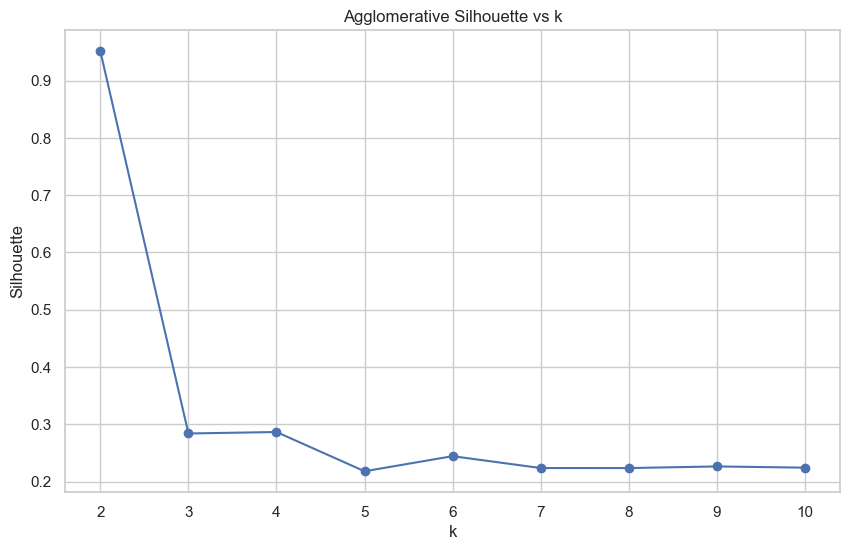

[Agglomerative k=2] silhouette=0.951  CH=1135.3  DB=0.422


{'silhouette': 0.9512544550961696,
 'ch': 1135.2895587878288,
 'db': 0.42156366807040907}

In [15]:
agg_scores = []
for k in k_range:
    agg = AgglomerativeClustering(n_clusters=k, linkage="ward")
    labels_agg = agg.fit_predict(X)
    sc = summarize_scores(X, labels_agg, name=f"Agglomerative k={k}")
    agg_scores.append((k, sc["silhouette"] if sc else np.nan))

plt.plot([k for k,_ in agg_scores], [s for _,s in agg_scores], marker="o")
plt.title("Agglomerative Silhouette vs k"); plt.xlabel("k"); plt.ylabel("Silhouette")
plt.show()

best_k_agg = max(agg_scores, key=lambda x: x[1])[0]
agg_best = AgglomerativeClustering(n_clusters=best_k_agg, linkage="ward")
labels_agg = agg_best.fit_predict(X)
summarize_scores(X, labels_agg, name=f"Agglomerative k={best_k_agg}")

### 6.4. DBSCAN via k-distance knee

## What the code does

* Computes each point’s distance to its **15th nearest neighbor** (`minPts = 15`) using `NearestNeighbors`.
* Sorts those distances (`k_dists`) and plots them → the **k-distance curve**.
* The **“knee”** (sharp bend) of this curve is a data-driven estimate for **`eps`**.

```python
minPts = 15
nbrs = NearestNeighbors(n_neighbors=minPts).fit(X)
dists, _ = nbrs.kneighbors(X)
k_dists = np.sort(dists[:, -1])
plt.plot(k_dists)
plt.title(f"k-distance curve (k={minPts})"); plt.ylabel("distance"); plt.xlabel("sorted points")
```

## How to read the plot 

* The curve stays **flat** for most points (dense regions), then rises **sharply** at the end (sparser/noisy points).
* Pick **`eps`** near the **start of the steep rise** (the “knee”). This balances:

  * Not too small (would label many points as noise),
  * Not too large (would merge distinct clusters).

## Why this matters

* DBSCAN needs **`eps`** and **`min_samples`** (`minPts`) to discover **density-based clusters** and **noise**.
* The k-distance knee gives a principled, visual way to set **`eps`** before running DBSCAN.

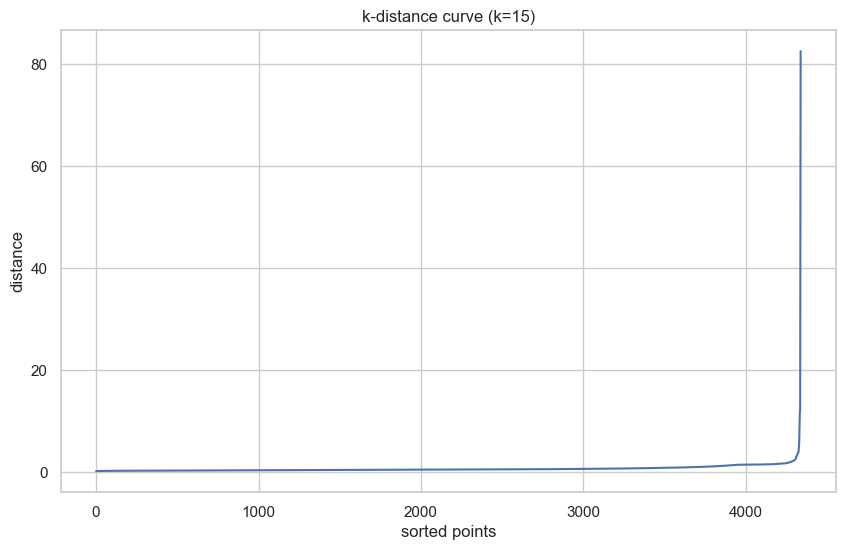

In [16]:
minPts = 15
nbrs = NearestNeighbors(n_neighbors=minPts).fit(X)
dists, _ = nbrs.kneighbors(X)
k_dists = np.sort(dists[:, -1])

plt.plot(k_dists)
plt.title(f"k-distance curve (k={minPts})"); plt.ylabel("distance"); plt.xlabel("sorted points")
plt.show()

## What the code does

* Finds an **`eps` candidate** from the **k-distance knee** (with `minPts = 15`):
  `eps ≈ 3.1483`.
* Fits **DBSCAN** with that `eps` and `min_samples = 15`.
* Reports intrinsic metrics and plots the labels on **UMAP(2)**.

## Output

* **`eps` candidate:** `3.1483`
* **Unique labels:** `[-1, 0]` → **one cluster** (`0`) and **noise** (`-1`) only.
* **Metrics:**

  * **Silhouette = 0.867** (looks great but misleading here)
  * **CH = 347.3**, **DB = 1.663**

## How to interpret this

* With just **one cluster + noise**, Silhouette can be **artificially high**; it’s **not a reliable quality signal** in this setting.
* Practically, this result means DBSCAN **didn’t discover multiple, useful segments** at the chosen parameters—most points formed a single dense group, a few were marked as noise.


## Bottom line

* For this dataset, the DBSCAN configuration above isn’t producing actionable segments. My earlier **K-Means (k=4)** solution remains the **best choice** for clear, stable clusters.


DBSCAN eps candidate: 3.148288593010254
DBSCAN unique labels: [-1  0]
[DBSCAN eps=3.148, minPts=15] silhouette=0.867  CH=347.3  DB=1.663


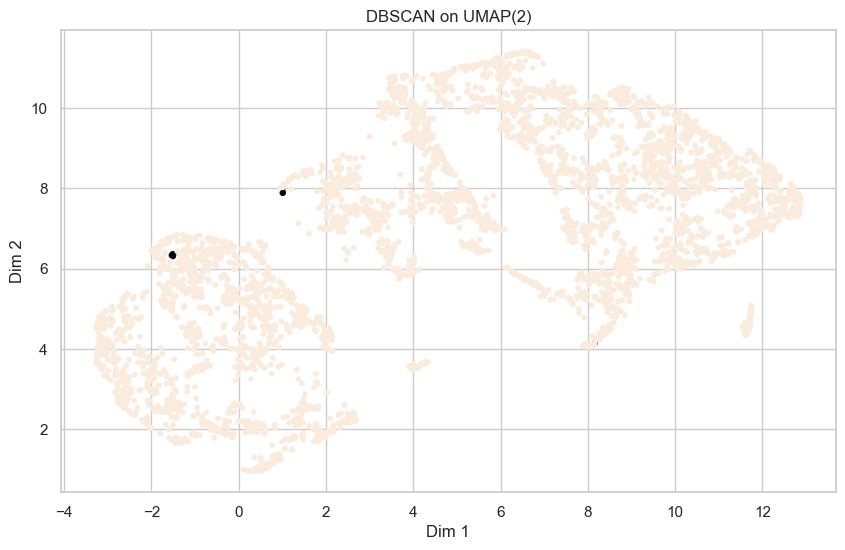

In [17]:
knee = KneeLocator(range(len(k_dists)), k_dists, curve='convex', direction='increasing')
eps_candidate = k_dists[knee.knee] if knee.knee is not None else np.percentile(k_dists, 95)
print("DBSCAN eps candidate:", float(eps_candidate))

db = DBSCAN(eps=float(eps_candidate), min_samples=minPts, n_jobs=-1)
labels_db = db.fit_predict(X)
print("DBSCAN unique labels:", np.unique(labels_db))
summarize_scores(X, labels_db, name=f"DBSCAN eps={eps_candidate:.3f}, minPts={minPts}")

plot_scatter_2d(X_umap2, labels_db, "DBSCAN on UMAP(2)")

### 6.5. HDBSCAN (density-based, hierarchical)

## What the code does

* Fits **HDBSCAN** with `min_cluster_size=50`, `min_samples=15` (with `prediction_data=True` so I can get soft memberships/outlier scores).
* Produces **hard labels** for each customer and plots them on the **UMAP(2)** embedding.

## Output 

* **Unique labels:** `[-1, 0, 1]` → **2 tiny clusters** (`0`, `1`) and a large **noise** group (`-1`).
* **Metrics:**

  * **Silhouette:** **0.008** (≈ no separation)
  * **Calinski–Harabasz:** **45.6** (very low)
  * **Davies–Bouldin:** **4.021** (high/overlap)

## Interpretation

* With these settings HDBSCAN treats **most points as noise** and only carves out a few dense pockets—great for **anomaly detection**, but **not** for broad customer segmentation here.
* Very low Silhouette and high DB confirm **poorly separated** clusters relative to K-Means $k=4$.


## Bottom line

* For **actionable customer segments**, my **K-Means (k=4)** remains the best choice on this dataset.
* Keep **HDBSCAN** in my appendix as a **density/anomaly** analysis with the tuning options above.


C:\Users\Ryan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Ryan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


HDBSCAN unique labels: [-1  0  1]
[HDBSCAN] silhouette=0.008  CH=45.6  DB=4.021


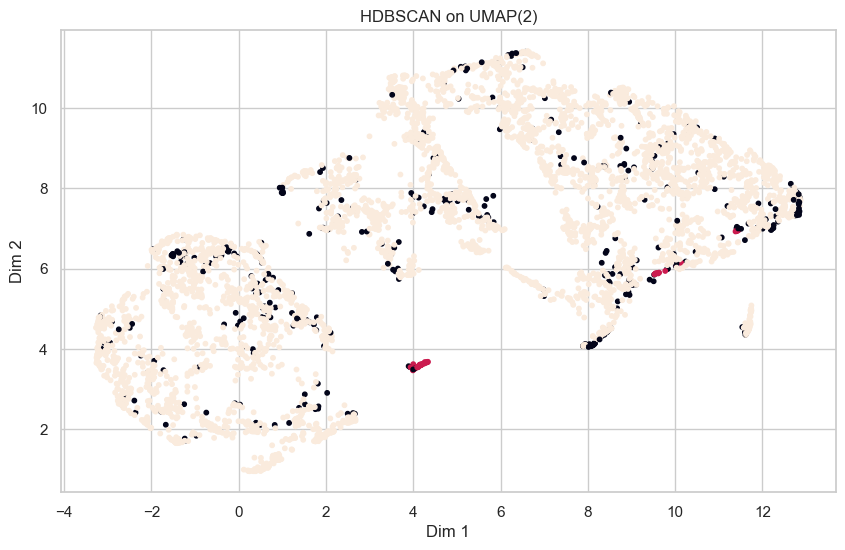

In [18]:
hdb = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=15, prediction_data=True)
labels_hdb = hdb.fit_predict(X)
print("HDBSCAN unique labels:", np.unique(labels_hdb))
summarize_scores(X, labels_hdb, name="HDBSCAN")
plot_scatter_2d(X_umap2, labels_hdb, "HDBSCAN on UMAP(2)")

# 7) Choose a winner & profile clusters

## Cluster sizes

* **Cluster 0:** 1,980 customers (\~**45.6%**)
* **Cluster 1:** 2,355 customers (\~**54.3%**)
* **Cluster 2:** **1** customer (outlier)
* **Cluster 3:** **2** customers (outliers)
  ➡️ Practically, the population splits into **two main segments** (0 & 1). Clusters 2–3 are **edge cases** / anomalies.

## Personas (based on mean/median profile table)

**Cluster 0 — Engaged multi-item shoppers**

* **RecencyDays:** \~36 (recent/active)
* **FrequencyInvoices:** \~7.5
* **MonetaryTotal:** \~£3.8k
* **ProductVariety:** \~110 unique items
* **AvgBasketQty / Lines/Invoice:** large (\~287 qty / \~28 lines)
* **AvgUnitPrice / ItemQty:** \~£3.22 / \~17
  **Actions:** VIP perks, early access, cross-sell curated bundles, replenish campaigns.

**Cluster 1 — Low-frequency value shoppers**

* **RecencyDays:** \~139 (inactive window)
* **FrequencyInvoices:** \~1.6
* **MonetaryTotal:** \~£444
* **ProductVariety:** \~21
* **AvgBasketQty / Lines/Invoice:** smaller (\~177 qty / \~16 lines)
* **AvgUnitPrice / ItemQty:** slightly higher unit price (\~£4.65), smaller per-line qty (\~26 median \~10)
  **Actions:** Win-back emails, threshold/free-shipping offers, seasonal reminders.

**Clusters 2 & 3 — Extreme outliers**

* Tiny counts (**1** and **2** customers).
* **Very large** Monetary/Basket values (e.g., cluster 3 Monetary ≈ **£122k**, AvgBasketQty ≈ **57k**).
  **Actions:** Treat as **VIP/special accounts** or **data-quality checks** (possible entry/aggregation anomalies). Consider excluding from model training or winsorizing before re-fit.

## Country mix (row-normalized)

* **UK dominates** both major clusters:

  * Cluster 0: **\~89.1% UK**
  * Cluster 1: **\~91.4% UK**
* Outlier clusters (2–3) show **100% UK** (given their size).
  **Implication:** Geography is **not** the primary driver of segmentation here; behavior features dominate. 

## Takeaways

* The **two actionable segments** are clusters **0** (high-engagement/high-value) and **1** (low-frequency/low-value).
* **Outliers** (clusters 2–3) should be **handled separately** (investigate or exclude) to avoid skewing centroids and narratives.
* Use these profiles to name segments and attach **targeted campaigns** (VIP perks vs. reactivation/discounts).


In [19]:
labels = labels_km

cust_seg = cust.copy()
cust_seg["cluster"] = labels

print("Cluster sizes:")
display(cust_seg["cluster"].value_counts().sort_index())

profile_cols = ["RecencyDays","FrequencyInvoices","MonetaryTotal","ProductVariety",
                "AvgBasketQty","AvgLinesPerInvoice","AvgUnitPrice","AvgItemQty"]

print("Cluster profile (mean/median):")
display(cust_seg.groupby("cluster")[profile_cols].agg(["mean","median"]).round(2))

print("Country mix per cluster (row-normalized):")
country_mix = (cust_seg
               .groupby(["cluster","Country"])
               .size()
               .groupby(level=0)
               .apply(lambda s: s/s.sum())
               .unstack(fill_value=0)
               .round(3))
display(country_mix.head())



Cluster sizes:


cluster
0    1980
1    2355
2       1
3       2
Name: count, dtype: int64

Cluster profile (mean/median):


RecencyDays        FrequencyInvoices        MonetaryTotal             \
               mean median              mean median          mean     median   
cluster                                                                        
0             36.53   22.0              7.45    5.0       3846.97    1773.72   
1            138.69  107.0              1.61    1.0        444.47     327.70   
2             85.00   85.0              1.00    1.0       2033.10    2033.10   
3            162.50  162.5              1.50    1.5     122828.05  122828.05   

        ProductVariety        AvgBasketQty           AvgLinesPerInvoice  \
                  mean median         mean    median               mean   
cluster                                                                   
0               109.97   84.0       286.63    212.50              28.35   
1                20.83   18.0       177.22    123.00              15.79   
2                 1.00    1.0         1.00      1.00               1.00   
3                 2.00    2.0     57356.75  57356.75               1.25   

               AvgUnitPrice          AvgItemQty            
        median         mean   median       mean    median  
cluster                                                    
0        22.04         3.22     2.84      16.95     10.06  
1        13.00         4.65     2.99      25.79      9.96  
2         1.00      2033.10  2033.10       1.00      1.00  
3         1.25         1.35     1.35   50607.00  50607.00

Country mix per cluster (row-normalized):


,Country,Australia,Austria,Bahrain,Belgium,Brazil,Canada,Channel Islands,Cyprus,Czech Republic,Denmark,...,RSA,Saudi Arabia,Singapore,Spain,Sweden,Switzerland,USA,United Arab Emirates,United Kingdom,Unspecified
cluster,cluster,,,,,,,,,,,,,,,,,,,,,
0,0,0.002,0.001,0.000,0.008,0.0,0.001,0.003,0.002,0.0,0.003,...,0.001,0.0,0.001,0.008,0.002,0.005,0.001,0.000,0.891,0.001
1,1,0.002,0.003,0.001,0.003,0.0,0.001,0.002,0.001,0.0,0.001,...,0.000,0.0,0.000,0.006,0.002,0.004,0.001,0.001,0.914,0.001
2,2,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.0,0.000,...,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
3,3,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.0,0.000,...,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000


# Radar chart (scaled)

## What the code does

* **Aggregates** each cluster’s mean on key features: `RecencyDays`, `FrequencyInvoices`, `MonetaryTotal`, `ProductVariety`, `AvgBasketQty`.
* **Scales 0–1** per feature with `MinMaxScaler` (by cluster means), so polygons are comparable across axes.
* **Plots a polar “radar” chart** where each cluster is a closed line connecting the scaled values on the five axes.

## How to read it

* **Farther from center = higher value** on that feature (after 0–1 scaling).
* **RecencyDays note:** higher means **more days since last purchase** (less recent). 
* The chart summarizes segment “shapes”:

  * **Cluster 0 (engaged multi-item)** → relatively **lower RecencyDays** and **higher Frequency/Variety** (bigger polygon on those axes).
  * **Cluster 1 (low-frequency value)** → **higher RecencyDays**, **lower Frequency/Variety**.
  * **Clusters 2 & 3 (outliers)** → extreme **MonetaryTotal / AvgBasketQty** spikes that distort scales.

## takeaway

* The radar confirms two actionable segments: **Cluster 0** has **recent, frequent, diverse** purchasing; **Cluster 1** is **infrequent and less diverse**—while **Clusters 2–3** are **edge-case spenders** best handled as outliers or VIPs in reporting.


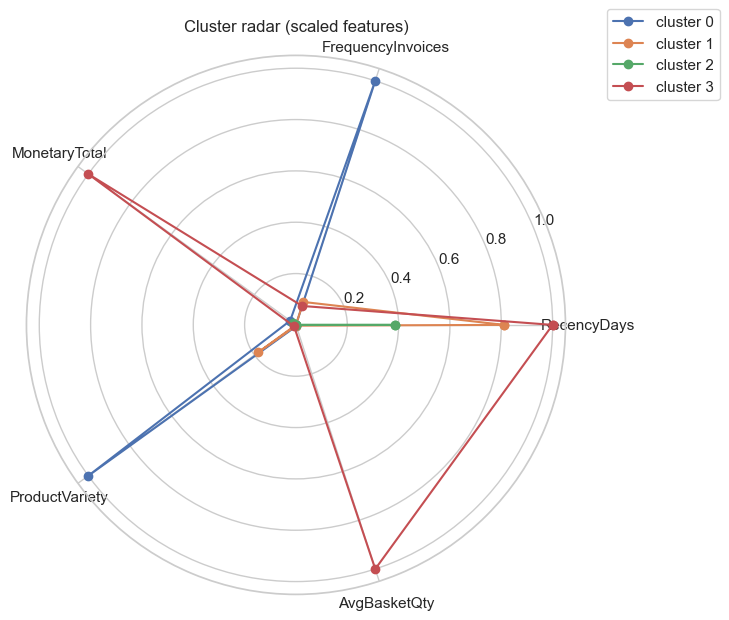

In [20]:
radar_cols = ["RecencyDays","FrequencyInvoices","MonetaryTotal","ProductVariety","AvgBasketQty"]
radar = cust_seg.groupby("cluster")[radar_cols].mean()
radar_scaled = pd.DataFrame(MinMaxScaler().fit_transform(radar), index=radar.index, columns=radar.columns)

angles = np.linspace(0, 2*np.pi, len(radar_cols), endpoint=False).tolist()
angles += angles[:1]
plt.figure(figsize=(7,7))
for idx, row in radar_scaled.iterrows():
    vals = row.values.tolist() + [row.values[0]]
    plt.polar(angles, vals, marker="o", label=f"cluster {idx}")
plt.xticks(angles[:-1], radar_cols)
plt.title("Cluster radar (scaled features)")
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
plt.show()

#### Top products by revenue per cluster (for naming personas)

## What the code does

* **Maps cluster labels back to transactions:** `dfA["cluster"] = dfA["CustomerID"].map(labels_map)`.
* **Aggregates revenue by item within each cluster:** groups by `["cluster", "Description"]`, sums `LineAmount`.
* **Ranks products per cluster:** sorts by revenue and keeps the **top 10** items for each cluster.

## What my results show (high level)

* I effectively get a **shopping “fingerprint”** for every segment—great for naming personas and targeting promos.

### Cluster 0 — “Decor & Gifting Enthusiasts”

* Top items (by revenue): **REGENCY CAKESTAND 3 TIER**, **WHITE HANGING HEART T-LIGHT HOLDER**, **JUMBO BAG RED RETROSPOT**, **PARTY BUNTING**, **ASSORTED COLOUR BIRD ORNAMENT**, **RABBIT NIGHT LIGHT**.
* Story: décor/gifting skew with multiple small home accessories.

### Cluster 1 — “Occasional Homeware Buyers”

* Top items: **PICNIC BASKET WICKER 60 PIECES**, **REGENCY CAKESTAND 3 TIER**, **PARTY BUNTING**, **WHITE HANGING HEART T-LIGHT HOLDER**, **CHILLI LIGHTS**, **JUMBO BAG RED RETROSPOT**.
* Story: overlap with cluster 0 but at **lower spend/frequency** (fits earlier profile).

### Cluster 3 — “Bulk Craft/Storage Outlier” (tiny cluster of 2 customers)

* Top items: **PAPER CRAFT , LITTLE BIRDIE** (≈ 168k), **MEDIUM CERAMIC TOP STORAGE JAR** (≈ 77k).
* Story: extreme bulk purchasing—likely **wholesale/institutional** or a data anomaly. Handle separately.

### Cluster 2 — “Administrative/Edge Case” (single customer)

* Top item: **Manual** (≈ 2k).
* Story: not representative; treat as outlier.


## Why this is useful

* Lets me **name segments** and align offers:

  * Cluster 0 → curated décor bundles, early access to seasonal lines.
  * Cluster 1 → reactivation + small-homeware promos.
  * Outliers → account-managed pricing, bespoke offers.



In [21]:
labels_map = cust_seg["cluster"].to_dict()  # CustomerID -> cluster
dfA["cluster"] = dfA["CustomerID"].map(labels_map)

topN = (dfA.groupby(["cluster","Description"])["LineAmount"]
          .sum()
          .sort_values(ascending=False)
          .groupby(level=0)
          .head(10)
          .reset_index())
print("Top products by revenue per cluster (top 10 each):")
display(topN.head(30))


Top products by revenue per cluster (top 10 each):


,cluster,Description,LineAmount
0,3,"PAPER CRAFT , LITTLE BIRDIE",168469.60
1,0,REGENCY CAKESTAND 3 TIER,129016.75
2,0,WHITE HANGING HEART T-LIGHT HOLDER,89970.25
3,3,MEDIUM CERAMIC TOP STORAGE JAR,77183.60
4,0,JUMBO BAG RED RETROSPOT,76561.84
5,0,POSTAGE,67606.61
6,0,PARTY BUNTING,57401.63
7,0,ASSORTED COLOUR BIRD ORNAMENT,49846.25
8,0,RABBIT NIGHT LIGHT,49274.60
9,0,Manual,48834.67
